# Evaluation of Analyzers using Input Perturbations
This notebook will guide you through an example how to evaluate analyzers via perturbing the input according to the importance that the different input dimensions have.

In particular, several analyzers will be applied to a simple multi-layer perceptron trained on MNIST digits, namely:
* Sensitivity Analysis
* Deconvolution
* Layer-wise relevance propagation

The input pixels are divided into quadratic regions that **sorted according to their importance** assigned by those analyzers. Then, the **information in the most important regions is destroyed** by perturbating them and the effect of the perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed. Thus, different analyzers can be evaluated by looking at how quickly the performance drops, i.e. the better the analyzer finds the relevant regions in the image the quicker the performance should deteriorate.

As a reference, see: **Samek, Wojciech, et al.** "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

# Prepare the model, analyzers and data

In [2]:
import warnings
warnings.simplefilter('ignore')

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

from innvestigate.tools import Perturbation, PerturbationAnalysis

eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


### Load data

In [3]:
channels_first = keras.backend.image_data_format() == "channels_first"
data = mnistutils.fetch_data(channels_first) #returns x_train, y_train, x_test, y_test as numpy.ndarray
num_classes = len(np.unique(data[1]))

60000 train samples
10000 test samples


### Build and train the model

In [4]:
#         MODELNAME                      INPUT RANGE   EPOCHS   BATCH_SZ   MODEL CREATION KWARGS
models = {'mlp_2dense':                  ([-1, 1],     15,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'mlp_3dense':                  ([-1, 1],     20,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'cnn_2convb_2dense':           ([-.5, .5],   20,      64,        {}),

          # pre-trained model from [https://doi.org/10.1371/journal.pone.0130140 , http://jmlr.org/papers/v17/15-618.html]
          'pretrained_plos_long_relu':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_relu':  ([-1, 1],     0,       0,         {}),
          'pretrained_plos_long_tanh':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_tanh':  ([-1, 1],     0,       0,         {}),
          }
#Adapt and Play around!

modelname = 'pretrained_plos_long_relu'
activation_type = 'relu'
input_range, epochs, batch_size, kwargs = models[modelname]

# TODO split into several cells
data_preprocessed = (mnistutils.preprocess(data[0], input_range), data[1],
                     mnistutils.preprocess(data[2], input_range), data[3])

x_test, y_test = data_preprocessed[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.BatchSequence([x_test, y_test], batch_size=256)

model_without_softmax, model_with_softmax = mnistutils.create_model(channels_first, modelname, **kwargs)
mnistutils.train_model(model_with_softmax, data_preprocessed, batch_size=batch_size, epochs=epochs)
model_without_softmax.set_weights(model_with_softmax.get_weights())

Test loss: 0.029667357468790668
Test accuracy: 0.9917


# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `ratio`: In each perturbation step, the `ratio` * 100% most important pixels are perturbed.

In [9]:
perturbation_function = np.zeros_like  # Equivalently, we could provide the string "zeros"
region_shape  = (1, 1) 
steps = 1
ratio = 0.01  # Perturbate 1% of pixels per perturbation step

methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN                TITLE

    # Show input
    ("input",                 {},                       mnistutils.image,          "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      mnistutils.graymap,        "SmoothGrad"),
    ("integrated_gradients",  {},                       mnistutils.graymap,        "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {},                       mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    ("lrp.z_baseline",        {},                       mnistutils.heatmap,         "Gradient*Input"),
    ("lrp.z",                 {},                       mnistutils.heatmap,         "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,         "LRP-Epsilon"),
    ("lrp.composite_a",       {},                       mnistutils.heatmap,         "LRP-CompositeA"),
    #("lrp.composite_b",       {"epsilon": 1},           mnistutils.heatmap,         "LRP-CompositeB"),
    ]

# Select a method of your choice
method = methods[9]
print('Using method "{}".'.format(method[0]))

analyzer = innvestigate.create_analyzer(method[0],
                                        model_without_softmax,
                                        **method[1])
analyzer.fit(data_preprocessed[0],
                 pattern_type=activation_type,
                 batch_size=256, verbose=1)

Using method "lrp.epsilon".


### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (1, 1)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 5% most important pixels are perturbed.

In [10]:
perturbation = Perturbation(perturbation_function, region_shape=region_shape, in_place=True)
perturbation_analysis = PerturbationAnalysis(analyzer, model_with_softmax, generator, perturbation,
                                                 steps=steps, ratio=ratio)

## Evaluate the model after several perturbation steps

In [11]:
scores = perturbation_analysis.compute_perturbation_analysis()

Step 1


Scores:
[[0.04980308 0.9846    ]
 [0.09102328 0.9667    ]]


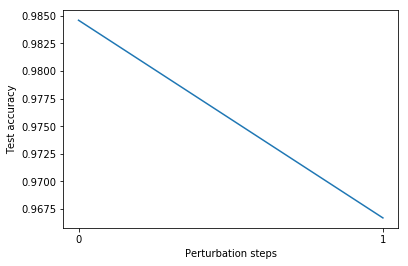

In [12]:
scores = np.array(scores)
print("Scores:")
print(scores)
plt.plot(scores[:, 1])
plt.xlabel("Perturbation steps")
plt.ylabel("Test accuracy")
plt.xticks(np.array(range(scores.shape[0])))
plt.show()

## 2. Plot perturbed sample

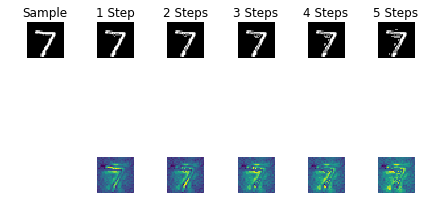

In [13]:
steps = 5

plt.figure()
plt.subplot(2, steps + 1, 1)
plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
plt.axis("off")
plt.title("Sample")

for i in range(steps):
    test_sample, analysis = perturbation_analysis.compute_on_batch(test_sample, return_analysis=True)
    
    plt.subplot(2, steps + 1, i + 2)
    plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
    plt.title("{} Step{}".format(i + 1, "" if i == 0 else "s"))
    plt.axis("off")
    
    plt.subplot(2, steps + 1, i + 2 + (steps + 1))
    plt.imshow(np.squeeze(analysis))
    plt.axis("off")
plt.tight_layout()  # Takes care of spaces between subfigures
plt.show()